# iWildCam 2019
### Deep Learning Project

This notebook is inspired by 
* https://www.kaggle.com/xhlulu/cnn-baseline-iwildcam-2019
* https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32
* https://pjreddie.com/media/files/papers/YOLOv3.pdf
* https://github.com/cfotache/pytorch_objectdetecttrack
* https://elitedatascience.com/imbalanced-classes

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import collections
import random

import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split

import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

## 1 Dataset

### 1.1 Exploring the Dataset

Inspired by https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32.

In [2]:
df_data = pd.read_csv('./input/train.csv')
df_data.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


Class spread


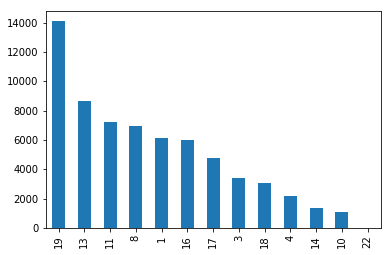

In [3]:
print("Class spread")
df_data['category_id'].value_counts()[1:16].plot(kind='bar')

In [4]:
classes = ['empty', 'deer', 'moose', 'squirrel', 'rodent', 'small_mammal', 
           'elk', 'pronghorn_antelope', 'rabbit', 'bighorn_sheep', 'fox', 
           'coyote', 'black_bear', 'raccoon', 'skunk', 'wolf', 'bobcat', 
           'cat', 'dog', 'opossum', 'bison', 'mountain_goat', 'mountain_lion']

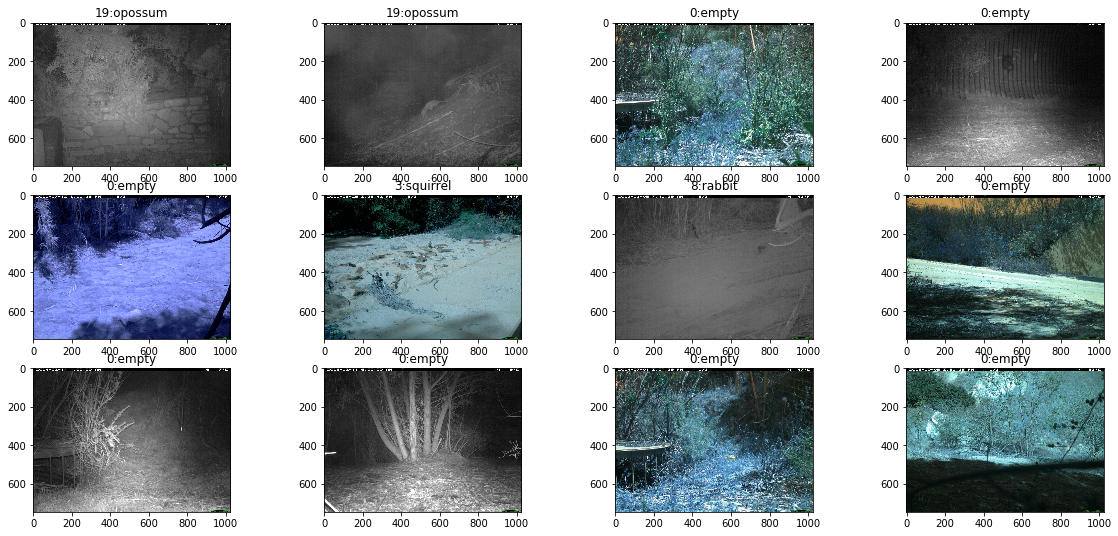

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'file_name']
        image_id = df.loc[i,'category_id']
        img = cv2.imread(f'./input/train_images/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title("{}:{}".format(image_id, classes[image_id]))
        plt.imshow(img)

display_samples(df_data)

## 1.2 Preprocessing the Dataset
* Load the 32x32 dataset (x_train, x_test) produced with https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32
* Change the dimension of the images from [32,32,3] to [3,32,32] (for Darknet model)
* Save data

In [6]:
preprocess = False

In [7]:
def change_array_dimension(images):
    """
    Change dimension of images from [32,32,3] to [3,32,32]
    
    Args:
    images                target images to be converted to different dimension
    num_images            total number of images included to result
    """
    images_temp = []
    for i in range(0, images.shape[0]):
        temp = []
        temp.append(images[i][:,:,0]) 
        temp.append(images[i][:,:,1])
        temp.append(images[i][:,:,2])
        images_temp.append(temp)
    images_temp = np.array(images_temp)
        
    return images_temp

In [21]:
#### Loading the 32x32 dataset ####
if preprocess:
    # The data, split between train and test sets:
    x_train = np.load('./input/preprocess/reducing-image-sizes-to-32x32/X_train.npy')
    x_test = np.load('./input/preprocess/reducing-image-sizes-to-32x32/X_test.npy')
    y_train = np.load('./input/preprocess/reducing-image-sizes-to-32x32/y_train.npy')
   
    # Convert the images to float and scale it to a range of 0 to 1
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.
    x_test /= 255.

    # Convert dimensions
    x_train = change_array_dimension(x_train)
    x_test = change_array_dimension(x_test)
    
    # Convert to numeric values
    y_train =  y_train.argmax(axis=1)
    
    #Save data
    np.save('./input/preprocess/changing-image-dimensions-to-3x32x32/x_train.npy', x_train)
    np.save('./input/preprocess/changing-image-dimensions-to-3x32x32/x_test.npy', x_test)
    np.save('./input/preprocess/changing-image-dimensions-to-3x32x32/y_train.npy', y_train)
else:
    # The data, split between train and test sets:
    x_train = np.load('./input/preprocess/changing-image-dimensions-to-3x32x32/x_train.npy')
    x_test = np.load('./input/preprocess/changing-image-dimensions-to-3x32x32/x_test.npy')
    y_train = np.load('./input/preprocess/changing-image-dimensions-to-3x32x32/y_train.npy')

#y_train = df_data['category_id']

In [9]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("Class spread: ", collections.Counter(y_train))

196299 train samples
153730 test samples
Class spread:  Counter({0: 131457, 19: 14106, 13: 8623, 11: 7209, 8: 6938, 1: 6102, 16: 5975, 17: 4759, 3: 3398, 18: 3035, 4: 2210, 14: 1361, 10: 1093, 22: 33})


Observe that the classes of the training samples are imbalanced and dominated by class 0 (empty image).

### 1.3 Handling Imbalanced Classes

* up-sample minority classes
* down-sample majority classes

Inspired by https://elitedatascience.com/imbalanced-classes.

In [22]:
max_count = 3000
all_indices = []
for class_id, class_count in collections.Counter(y_train).most_common():
    # Take the indices of current class
    indices = np.argwhere(y_train == class_id).squeeze()
    
    # Up- or down-sample the current class
    if class_count >= max_count: # Down-sample, take unique indices
        random_indices = list(random.sample(list(indices),max_count))
    else: #Up-sample, take all unique indices + duplicate indices
        random_indices = list(random.sample(list(indices),class_count))
        random_indices.extend(list(np.random.choice(indices,max_count-class_count)))
        
    # Add the selected indices of the class to list
    all_indices.extend(random_indices)

# Shuffle the order of the images
all_indices=np.random.permutation(all_indices)

y_train_len = len(y_train)
y_train = y_train[all_indices]
x_train = x_train[all_indices]

print("Reduced the amount of training samples from {} to {}".format(y_train_len, len(y_train)))
print("Class spread: ",collections.Counter(y_train))

Reduced the amount of training samples from 196299 to 42000
Class spread:  Counter({1: 3000, 0: 3000, 13: 3000, 6: 3000, 2: 3000, 3: 3000, 11: 3000, 8: 3000, 4: 3000, 10: 3000, 5: 3000, 12: 3000, 9: 3000, 7: 3000})


### 1.4 Splitting dataset to training and validation

In [23]:
# Split training data to two sets: use 90 % to train and 10 % to validate

# Create tensors and torch dataset
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
dataset = TensorDataset(x_train_tensor, y_train_tensor)

# Split the dataset
train_size = int(0.9 * x_train.shape[0])
validation_size = x_train.shape[0] - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
print("Train on {} samples, validate on {} samples".format(train_size, validation_size))

Train on 37800 samples, validate on 4200 samples


## 2 Creating the Model

<img src="darknet-architecture.JPG" width=300 style="float: right;">

 https://pjreddie.com/media/files/papers/YOLOv3.pdf


In [ ]:
CUDA = torch.cuda.is_available()
device = torch.device('cuda:0') if CUDA else torch.device('cpu')
print("Torch device: ", device)

img_size=32
num_classes = len(pd.Series(y_train).unique()) # Note that the training samples don't cover all the classes
print("Number of classes in total: ", len(classes))
print("Number of classes in training samples: ", num_classes)

Torch device:  cuda:0
Number of classes in total:  23
Number of classes in training samples:  14


In [14]:
class Darknet(nn.Module):
    def __init__(self, num_classes, img_size, use_leakyrelu=True):
        """
        Args:
        num_classes       number of classes used in Softmax
        img_size          size of the image used in Global average pooling
        use_leakyrelu     if True LeakyReLU is used instead of ReLU
        """
        super(Darknet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        #Layer 3 x1
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.1) if use_leakyrelu else nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        # Layer 5 x2
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.1) if use_leakyrelu else nn.ReLU())
    
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

        # Layer 7 x8
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.1) if use_leakyrelu else nn.ReLU())
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        # Layer 9 x8
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.1) if use_leakyrelu else nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        
        # Layer 11 x4
        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.1) if use_leakyrelu else nn.ReLU())
        
        self.layer12 = nn.AvgPool2d(kernel_size=img_size)
        
        self.layer13 = nn.Sequential(
            nn.Linear(img_size, 1000),
            nn.Linear(1000, num_classes))
        
        self.layer14 = nn.LogSoftmax(dim=0)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        for i in range(0,2): x = self.layer5(x)
        x = self.layer6(x)
        for i in range(0,8): x = self.layer7(x)
        x = self.layer8(x)
        for i in range(0,8): x = self.layer9(x)
        x = self.layer10(x)
        for i in range(0,4): x = self.layer11(x)
        x=x.view(x.shape[0],32,32,1)
        x = self.layer12(x).squeeze()
        x = self.layer13(x)
        x = self.layer14(x)
        return x

In [15]:
model = Darknet(num_classes,img_size)
print(model)

Darknet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## 3 Training the Model

In [ ]:
train = True

#Create dataloaders for training and validation
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

In [ ]:
def get_predictions(model, testloader):
    """
    Args:
    model              model used for predicting
    testloader         batched dataset for predicting
    """
    predictions = []
    real_values = []
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            real_values.extend(y.cpu().numpy())

    return np.array(predictions), np.array(real_values)

def get_accuracy_score(model, testloader):
    """
    Args:
    model              model used for predicting
    testloader         batched dataset for predicting and validating
    """
    predictions, real_values = get_predictions(model, testloader)
    return accuracy_score(predictions,real_values)

def train_model(model,dataloader,testloader,n_epochs,use_SGD_optimizer=True, verbose=True):
    """
    Args:
    model              model used for training
    dataloader         batched dataset for training
    testloader         batched dataset for validating
    n_epochs           number of epochs used in training
    use_SGD_optimizer  if True, SGD optimizer is used for training. Otherwise Adam.
    verbose            if True, statistics are printed
    """
    model.train()
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) if use_SGD_optimizer \
                    else optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(n_epochs):
        running_loss = 0.0

        for i, (x, y) in enumerate(dataloader, 0):
            x, y = x.to(device), y.to(device)
            # zero the parameter gradients         
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            # get statistics
            running_loss += loss.item()

        # print statistics per epoch
        if verbose:
            training_accuracy = get_accuracy_score(model,dataloader)
            validation_accuracy = get_accuracy_score(model,testloader)
            print("[{}] loss: {:.3f}, training accuracy: {:.3f}, validation accuracy: {:.3f}".format(
                        epoch+1, running_loss/len(dataloader), training_accuracy, validation_accuracy))
            torch.save(model.state_dict(), 'darknet_{}.pth'.format(epoch+101))
            
    if verbose: print('Finished Training')

In [19]:
if train:
    # Create the model
    model = Darknet(num_classes,img_size)
    model.to(device)

    # Train the model
    num_epochs = 30
    train_model(model,train_dataloader,validation_dataloader,num_epochs) 

    # Save the model
    torch.save(model.state_dict(), 'darknet.pth')
else:
    # Load the model
    model = Darknet(num_classes,img_size)
    model.load_state_dict(torch.load('darknet.pth', map_location=lambda storage, loc: storage))
    model.to(device)

[1] loss: 2.440, training accuracy: 0.272, validation accuracy: 0.257
[2] loss: 2.261, training accuracy: 0.397, validation accuracy: 0.392
[3] loss: 2.159, training accuracy: 0.432, validation accuracy: 0.425
[4] loss: 2.105, training accuracy: 0.448, validation accuracy: 0.429
[5] loss: 2.060, training accuracy: 0.457, validation accuracy: 0.439
[6] loss: 2.031, training accuracy: 0.442, validation accuracy: 0.422
[7] loss: 2.014, training accuracy: 0.467, validation accuracy: 0.446
[8] loss: 1.979, training accuracy: 0.470, validation accuracy: 0.453
[9] loss: 1.974, training accuracy: 0.468, validation accuracy: 0.444
[10] loss: 1.953, training accuracy: 0.472, validation accuracy: 0.447
[11] loss: 1.930, training accuracy: 0.486, validation accuracy: 0.456
[12] loss: 1.923, training accuracy: 0.497, validation accuracy: 0.463
[13] loss: 1.911, training accuracy: 0.485, validation accuracy: 0.455
[14] loss: 1.911, training accuracy: 0.487, validation accuracy: 0.455
[15] loss: 1.88

Classes 0..23
30 epochs
[1] loss: 2.440, training accuracy: 0.272, validation accuracy: 0.257
[2] loss: 2.261, training accuracy: 0.397, validation accuracy: 0.392
[3] loss: 2.159, training accuracy: 0.432, validation accuracy: 0.425
[4] loss: 2.105, training accuracy: 0.448, validation accuracy: 0.429
[5] loss: 2.060, training accuracy: 0.457, validation accuracy: 0.439
[6] loss: 2.031, training accuracy: 0.442, validation accuracy: 0.422
[7] loss: 2.014, training accuracy: 0.467, validation accuracy: 0.446
[8] loss: 1.979, training accuracy: 0.470, validation accuracy: 0.453
[9] loss: 1.974, training accuracy: 0.468, validation accuracy: 0.444
[10] loss: 1.953, training accuracy: 0.472, validation accuracy: 0.447
[11] loss: 1.930, training accuracy: 0.486, validation accuracy: 0.456
[12] loss: 1.923, training accuracy: 0.497, validation accuracy: 0.463
[13] loss: 1.911, training accuracy: 0.485, validation accuracy: 0.455
[14] loss: 1.911, training accuracy: 0.487, validation accuracy: 0.455
[15] loss: 1.883, training accuracy: 0.502, validation accuracy: 0.464
[16] loss: 1.876, training accuracy: 0.493, validation accuracy: 0.456
[17] loss: 1.865, training accuracy: 0.506, validation accuracy: 0.473
[18] loss: 1.850, training accuracy: 0.502, validation accuracy: 0.464
[19] loss: 1.863, training accuracy: 0.504, validation accuracy: 0.466
[20] loss: 1.845, training accuracy: 0.515, validation accuracy: 0.475
[21] loss: 1.818, training accuracy: 0.514, validation accuracy: 0.476
[22] loss: 1.818, training accuracy: 0.517, validation accuracy: 0.478
[23] loss: 1.816, training accuracy: 0.515, validation accuracy: 0.475
[24] loss: 1.817, training accuracy: 0.515, validation accuracy: 0.476
[25] loss: 1.825, training accuracy: 0.509, validation accuracy: 0.473
[26] loss: 1.807, training accuracy: 0.517, validation accuracy: 0.474
[27] loss: 1.806, training accuracy: 0.516, validation accuracy: 0.471
[28] loss: 1.785, training accuracy: 0.527, validation accuracy: 0.485
[29] loss: 1.778, training accuracy: 0.527, validation accuracy: 0.483
[30] loss: 1.773, training accuracy: 0.520, validation accuracy: 0.475
Finished Training

+60 epochs more
[1] loss: 1.922, training accuracy: 0.425, validation accuracy: 0.398
[2] loss: 1.795, training accuracy: 0.531, validation accuracy: 0.481
[3] loss: 1.754, training accuracy: 0.529, validation accuracy: 0.481
[4] loss: 1.737, training accuracy: 0.532, validation accuracy: 0.482
[5] loss: 1.726, training accuracy: 0.528, validation accuracy: 0.478
[6] loss: 1.726, training accuracy: 0.533, validation accuracy: 0.484
[7] loss: 1.713, training accuracy: 0.529, validation accuracy: 0.475
[8] loss: 1.712, training accuracy: 0.532, validation accuracy: 0.478
[9] loss: 1.705, training accuracy: 0.523, validation accuracy: 0.474
[10] loss: 1.702, training accuracy: 0.526, validation accuracy: 0.475
[11] loss: 1.701, training accuracy: 0.523, validation accuracy: 0.467
[12] loss: 1.697, training accuracy: 0.531, validation accuracy: 0.480
[13] loss: 1.689, training accuracy: 0.528, validation accuracy: 0.479
[14] loss: 1.688, training accuracy: 0.529, validation accuracy: 0.477
[15] loss: 1.684, training accuracy: 0.525, validation accuracy: 0.474
[16] loss: 1.680, training accuracy: 0.532, validation accuracy: 0.479
[17] loss: 1.674, training accuracy: 0.530, validation accuracy: 0.480
[18] loss: 1.668, training accuracy: 0.521, validation accuracy: 0.467
[19] loss: 1.666, training accuracy: 0.526, validation accuracy: 0.472
[20] loss: 1.657, training accuracy: 0.525, validation accuracy: 0.473
[21] loss: 1.653, training accuracy: 0.526, validation accuracy: 0.471
[22] loss: 1.643, training accuracy: 0.528, validation accuracy: 0.474
[23] loss: 1.637, training accuracy: 0.529, validation accuracy: 0.475
[24] loss: 1.641, training accuracy: 0.520, validation accuracy: 0.465
[25] loss: 1.635, training accuracy: 0.522, validation accuracy: 0.465
[26] loss: 1.623, training accuracy: 0.526, validation accuracy: 0.475
[27] loss: 1.626, training accuracy: 0.517, validation accuracy: 0.468
[28] loss: 1.619, training accuracy: 0.525, validation accuracy: 0.470
[29] loss: 1.614, training accuracy: 0.519, validation accuracy: 0.467
[30] loss: 1.604, training accuracy: 0.523, validation accuracy: 0.471
[31] loss: 1.600, training accuracy: 0.522, validation accuracy: 0.473
[32] loss: 1.588, training accuracy: 0.519, validation accuracy: 0.470
[33] loss: 1.593, training accuracy: 0.518, validation accuracy: 0.473
[34] loss: 1.576, training accuracy: 0.522, validation accuracy: 0.473
[35] loss: 1.566, training accuracy: 0.512, validation accuracy: 0.464
[36] loss: 1.574, training accuracy: 0.515, validation accuracy: 0.463
[37] loss: 1.570, training accuracy: 0.516, validation accuracy: 0.468
[38] loss: 1.566, training accuracy: 0.517, validation accuracy: 0.468
[39] loss: 1.552, training accuracy: 0.507, validation accuracy: 0.459
[40] loss: 1.540, training accuracy: 0.516, validation accuracy: 0.466
[41] loss: 1.539, training accuracy: 0.514, validation accuracy: 0.459
[42] loss: 1.539, training accuracy: 0.503, validation accuracy: 0.452
[43] loss: 1.520, training accuracy: 0.515, validation accuracy: 0.462
[44] loss: 1.526, training accuracy: 0.509, validation accuracy: 0.453
[45] loss: 1.510, training accuracy: 0.505, validation accuracy: 0.450
[46] loss: 1.507, training accuracy: 0.499, validation accuracy: 0.445
[47] loss: 1.498, training accuracy: 0.502, validation accuracy: 0.443
[48] loss: 1.495, training accuracy: 0.506, validation accuracy: 0.454
[49] loss: 1.481, training accuracy: 0.494, validation accuracy: 0.442
[50] loss: 1.483, training accuracy: 0.508, validation accuracy: 0.455
[51] loss: 1.476, training accuracy: 0.504, validation accuracy: 0.447
[52] loss: 1.468, training accuracy: 0.484, validation accuracy: 0.435
[53] loss: 1.459, training accuracy: 0.497, validation accuracy: 0.447
[54] loss: 1.454, training accuracy: 0.504, validation accuracy: 0.454
[55] loss: 1.441, training accuracy: 0.494, validation accuracy: 0.445
[56] loss: 1.440, training accuracy: 0.493, validation accuracy: 0.445
[57] loss: 1.432, training accuracy: 0.491, validation accuracy: 0.443
[58] loss: 1.434, training accuracy: 0.489, validation accuracy: 0.438
[59] loss: 1.422, training accuracy: 0.483, validation accuracy: 0.437
[60] loss: 1.411, training accuracy: 0.482, validation accuracy: 0.438
Finished Training

In [ ]:
# WITH y -> 0..13
# Create the model
model = Darknet(num_classes,img_size)
model.to(device)

# Train the model
num_epochs = 60
train_model(model,train_dataloader,validation_dataloader,num_epochs) 
# [9] loss: 0.840, training accuracy: 0.897, validation accuracy: 0.808

[1] loss: 2.114, training accuracy: 0.422, validation accuracy: 0.415
[2] loss: 1.746, training accuracy: 0.501, validation accuracy: 0.483
[3] loss: 1.588, training accuracy: 0.575, validation accuracy: 0.553
[4] loss: 1.461, training accuracy: 0.585, validation accuracy: 0.567
[5] loss: 1.389, training accuracy: 0.639, validation accuracy: 0.615
[6] loss: 1.326, training accuracy: 0.653, validation accuracy: 0.630
[7] loss: 1.296, training accuracy: 0.676, validation accuracy: 0.646
[8] loss: 1.231, training accuracy: 0.688, validation accuracy: 0.651
[9] loss: 1.189, training accuracy: 0.702, validation accuracy: 0.671
[10] loss: 1.158, training accuracy: 0.718, validation accuracy: 0.679
[11] loss: 1.123, training accuracy: 0.722, validation accuracy: 0.677
[12] loss: 1.100, training accuracy: 0.735, validation accuracy: 0.690
[13] loss: 1.069, training accuracy: 0.726, validation accuracy: 0.684
[14] loss: 1.046, training accuracy: 0.749, validation accuracy: 0.699
[15] loss: 1.03

## 4 Evaluating the Model

In [ ]:
training_predictions, training_real_values = get_predictions(model,train_dataloader)
validation_predictions, validation_real_values = get_predictions(model,validation_dataloader)
print("Training accuracy: {}, Validation accuracy: {}".format(accuracy_score(training_predictions,training_real_values),
                                                             accuracy_score(validation_predictions,validation_real_values)))

In [ ]:
def create_confusion_matrix(y_test, y_pred, classifier_name='Darknet-53', classes=[]):
    c_matrix = confusion_matrix(y_test, y_pred, labels=classes) 
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_title("{} confusion matrix".format(classifier_name))
    sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
    #plt.savefig('{}.jpg'.format(classifier_name.replace(' ','')))
    plt.show()

In [ ]:
# def fix_labels(input):
#     wrong_labels = collections.Counter(y_train).most_common()
#     correct_labels = collections.Counter(y_train_correct_labels).most_common()
#     wrong_labels = list(list(zip(*wrong_labels))[0])
#     correct_labels = list(list(zip(*correct_labels))[0])

#     for i in range(0,len(input)):
#         j = wrong_labels.index(input[i])
#         input[i]=correct_labels[j]

In [ ]:
# fix_labels(training_real_values)
# fix_labels(training_predictions)

print("Confusion matrix for training images")
create_confusion_matrix(training_real_values,training_predictions,classes=range(0,len(classes)))

In [ ]:
# fix_labels(validation_real_values)
# fix_labels(validation_predictions)

print("Confusion matrix for validation images")
create_confusion_matrix(validation_real_values,validation_predictions,classes=range(0,len(classes)))

## 5 Predicting Labels for Submission

In [ ]:
num_images = x_test.shape[0]
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor_dummy = torch.LongTensor(np.zeros(num_images))
dataset = TensorDataset(x_test_tensor, y_test_tensor_dummy)
dataloader = DataLoader(dataset, batch_size=batch_size)
predictions, real_values = get_predictions(model, dataloader)
#print(collections.Counter(predictions).most_common())
#fix_labels(predictions)
#print(collections.Counter(predictions).most_common())

submission_df = pd.read_csv('./input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = predictions
print(submission_df.shape)
submission_df.head()

submission_df.to_csv('darknet_submission.csv',index=False)

In [ ]:
submission_df.head()

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'Id']
        image_id = df.loc[i,'Predicted']
        img = cv2.imread(f'./input/test_images/{image_path}.jpg')
        fig.add_subplot(rows, columns, i+1)
        plt.title("{}:{}".format(image_id, classes[image_id]))
        plt.imshow(img)

display_samples(submission_df)